# Aerospike Connect for Spark Tutorial for Python
## Tested with Java 8, Spark 2.4.0, and Python 3.7

### Setup

Below, a seed address for your Aerospike database cluster is required

Check the given namespace is available, and your feature key is located as per AS_FEATURE_KEY_PATH

Finally, review https://www.aerospike.com/enterprise/download/connectors/ to ensure AEROSPIKE_SPARK_JAR_VERSION is correct

In [1]:
# IP Address or DNS name for one host in your Aerospike cluster
AS_HOST ="10.0.0.236"
# Name of one of your namespaces. Type 'show namespaces' at the aql prompt if you are not sure
AS_NAMESPACE = "test" 
AS_FEATURE_KEY_PATH = "/etc/aerospike/features.conf"
AEROSPIKE_SPARK_JAR_VERSION="2.4.0"

AS_PORT = 3000 # Usually 3000, but change here if not
AS_CONNECTION_STRING = AS_HOST + ":"+ str(AS_PORT)

In [2]:
# Next we locate the Spark installation - this will be found using the SPARK_HOME environment variable that you will have set 
# if you followed the repository README

import findspark
findspark.init()

In [3]:
# Here we download the Aerospike Spark jar
import urllib
import os

def aerospike_spark_jar_download_url(version=AEROSPIKE_SPARK_JAR_VERSION):
    DOWNLOAD_PREFIX="https://www.aerospike.com/enterprise/download/connectors/aerospike-spark/"
    DOWNLOAD_SUFFIX="/artifact/jar"
    AEROSPIKE_SPARK_JAR_DOWNLOAD_URL = DOWNLOAD_PREFIX+AEROSPIKE_SPARK_JAR_VERSION+DOWNLOAD_SUFFIX
    return AEROSPIKE_SPARK_JAR_DOWNLOAD_URL

def download_aerospike_spark_jar(version=AEROSPIKE_SPARK_JAR_VERSION):
    JAR_NAME="aerospike-spark-assembly-"+AEROSPIKE_SPARK_JAR_VERSION+".jar"
    if(not(os.path.exists(JAR_NAME))) :
        urllib.request.urlretrieve(aerospike_spark_jar_download_url(),JAR_NAME)
    else :
        print(JAR_NAME+" already downloaded")
    return os.path.join(os.getcwd(),JAR_NAME)

AEROSPIKE_JAR_PATH=download_aerospike_spark_jar()
os.environ["PYSPARK_SUBMIT_ARGS"] = '--jars ' + AEROSPIKE_JAR_PATH + ' pyspark-shell'



aerospike-spark-assembly-2.4.0.jar already downloaded


In [4]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StringType, StructField, StructType, ArrayType, IntegerType, MapType, LongType

Get a spark session object and set required Aerospike configuration properties

In [27]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)
spark.conf.set("aerospike.namespace",AS_NAMESPACE)
spark.conf.set("aerospike.seedhost",AS_CONNECTION_STRING)
spark.conf.set("aerospike.keyPath",AS_FEATURE_KEY_PATH )


## Create sample data and write to Aerospike database

In [43]:
# Create 500 id/name/age/salary records - initially in a Python array
import random
num_records=500

schema = StructType( 
    [
        StructField("id", IntegerType(), True),
        StructField("name", StringType(), True),
        StructField("age", IntegerType(), True),
        StructField("salary",IntegerType(), True)
    ]
)

inputBuf = []

## Create num_records records
for  i in range(1, num_records + 1) :
         name = "Individual: {:03d}".format(i)
         age = random.randint(25,60)
         salary = 50000 + random.randint(1,50000)
         id = i 
         inputBuf.append((id, name, age,salary))
    
# Convert to a Data Frame    
inputRDD = spark.sparkContext.parallelize(inputBuf)
inputDF=spark.createDataFrame(inputRDD,schema)

#Write the data frame to Aerospike, the id field is used as the primary key
inputDF \
.write \
.mode('overwrite') \
.format("com.aerospike.spark.sql")  \
.option("aerospike.set", "salary_data")\
.option("aerospike.updateByKey", "id") \
.save()

## Use of schema

Aerospike is schemaless, however Spark data frames do. If a schema is not explicitly supplied it will 
be inferred from the data within the data frame.

Once this takes place, data within the data frame must honor the types. 

To infer schema, the connector samples a set of records (configurable through `aerospike.schema.scan`) to decide the name of bins/columns and their types. 


## Load data into a DataFrame without specifying any Schema (uses schema inference)

In [44]:
# Create a Spark DataFrame by using the Connector Schema inference mechanism
# The fields preceded with __ are metadata fields - key/digest/expiry/generation/ttl
# By default you just get everything, with no column ordering, which is why it looks untidy
# Note we don't get anything in the 'key' field as we have not chosen to save as a bin.
# Use .option("aerospike.sendKey", True) to do this

loadedDFWithoutSchema = (
    spark.read.format("com.aerospike.spark.sql") \
    .option("aerospike.set", "salary_data") \
    .load()
)

loadedDFWithoutSchema.show()

+-----+--------------------+--------+------------+-----+---+---------------+------+---+
|__key|            __digest|__expiry|__generation|__ttl|age|           name|salary| id|
+-----+--------------------+--------+------------+-----+---+---------------+------+---+
| null|[03 50 2E 7F 70 9...|       0|           1|   -1| 57|Individual: 239| 91612|239|
| null|[04 C0 5E 9A 68 5...|       0|           1|   -1| 53|Individual: 101| 83611|101|
| null|[0F 10 1A 93 B1 E...|       0|           1|   -1| 45|Individual: 194| 97233|194|
| null|[13 40 1A 35 CA 0...|       0|           1|   -1| 46|Individual: 323| 55207|323|
| null|[1A E0 A8 A0 F2 3...|       0|           1|   -1| 41|Individual: 031| 68510| 31|
| null|[1F 40 90 C0 94 B...|       0|           1|   -1| 35|Individual: 479| 52338|479|
| null|[23 20 78 35 5D 7...|       0|           1|   -1| 46|Individual: 139| 61982|139|
| null|[35 00 8C 78 43 F...|       0|           1|   -1| 43|Individual: 014| 87575| 14|
| null|[37 D0 AA 5F 9B C...|    

## Load data into a DataFrame using user specified schema 

In [45]:
# If we explicitly set the schema, using the previously created schema object
# we effectively type the rows in the Data Frame

loadedDFWithSchema=spark \
.read \
.format("com.aerospike.spark.sql") \
.schema(schema) \
.option("aerospike.set", "salary_data").load()

loadedDFWithSchema.show(5)

+---+---------------+---+------+
| id|           name|age|salary|
+---+---------------+---+------+
|239|Individual: 239| 57| 91612|
|101|Individual: 101| 53| 83611|
|194|Individual: 194| 45| 97233|
|323|Individual: 323| 46| 55207|
| 31|Individual: 031| 41| 68510|
+---+---------------+---+------+
only showing top 5 rows



## SparkML with Aerospike

### The purpose of this ML model is to illustrate how data in Aerospike can be used for training and inference using SparkML 
#### A K-Means clustering model is used to create several segments based on age and salary.

In [9]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler


#All machine learning algorithms in Spark take as input a Vector type, which must be a set of numerical values.
assembler = VectorAssembler(
    inputCols=["_id", "age", "salary"],
    outputCol="features")
data_2 = assembler.transform(loadedDFWithSchema)
data_2.show()

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(data_2)

# Make predictions
predictions = model.transform(data_2)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

+---+-------+---+------+--------------------+
|_id|   name|age|salary|            features|
+---+-------+---+------+--------------------+
|604|name604|  4| 99081| [604.0,4.0,99081.0]|
| 10| name10| 10| 94662| [10.0,10.0,94662.0]|
|586|name586| 86| 68311|[586.0,86.0,68311.0]|
|477|name477| 77| 82885|[477.0,77.0,82885.0]|
| 50| name50| 50| 76844| [50.0,50.0,76844.0]|
|554|name554| 54| 73406|[554.0,54.0,73406.0]|
|964|name964| 64| 87713|[964.0,64.0,87713.0]|
|880|name880| 80| 88669|[880.0,80.0,88669.0]|
|859|name859| 59| 96151|[859.0,59.0,96151.0]|
|227|name227| 27| 59420|[227.0,27.0,59420.0]|
|812|name812| 12| 56342|[812.0,12.0,56342.0]|
|780|name780| 80| 53021|[780.0,80.0,53021.0]|
|555|name555| 55| 67400|[555.0,55.0,67400.0]|
|185|name185| 85| 92506|[185.0,85.0,92506.0]|
|221|name221| 21| 73437|[221.0,21.0,73437.0]|
|117|name117| 17| 56226|[117.0,17.0,56226.0]|
|706|name706|  6| 71844| [706.0,6.0,71844.0]|
|358|name358| 58| 56574|[358.0,58.0,56574.0]|
|438|name438| 38| 67480|[438.0,38.

## Writing Sample Complex Data Types (CDT) data into Aerospike

In [10]:
complex_data_json="resources/nested_data.json"
alias=  StructType( [
    StructField("first_name",StringType(), False),
    StructField("last_name",StringType(), False)]
)

name= StructType([
    StructField("first_name",StringType(), False), 
    StructField("aliases",ArrayType(alias), False)]
)
street_adress= StructType([StructField("street_name", StringType(), False), StructField("apt_number", IntegerType(), False)])
address = StructType([StructField("zip", LongType(), False), StructField("street", street_adress, False), StructField("city", StringType(), False)])

workHistory = StructType([StructField ("company_name" , StringType(), False),
                              StructField( "company_address" , address, False),
                              StructField("worked_from", StringType(), False)]
                        )

person= StructType([StructField("name", name, False),
                        StructField("SSN", StringType(), False),
                        StructField("home_address", ArrayType(address), False),
                        StructField("work_history", ArrayType(workHistory), False)]
                  )

cmplx_data_with_schema=spark.read.schema(person).json(complex_data_json)
cmplx_data_with_schema.printSchema()

cmplx_data_with_schema \
.write \
.mode('overwrite') \
.format("com.aerospike.spark.sql")  \
.option("aerospike.seedhost", AS_HOST) \
.option("aerospike.namespace", AS_NAMESPACE) \
.option("aerospike.writeset", "complex_input_data") \
.option("aerospike.updateByKey", "name.first_name") \
.save()

root
 |-- name: struct (nullable = true)
 |    |-- first_name: string (nullable = true)
 |    |-- aliases: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- first_name: string (nullable = true)
 |    |    |    |-- last_name: string (nullable = true)
 |-- SSN: string (nullable = true)
 |-- home_address: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- zip: long (nullable = true)
 |    |    |-- street: struct (nullable = true)
 |    |    |    |-- street_name: string (nullable = true)
 |    |    |    |-- apt_number: integer (nullable = true)
 |    |    |-- city: string (nullable = true)
 |-- work_history: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- company_name: string (nullable = true)
 |    |    |-- company_address: struct (nullable = true)
 |    |    |    |-- zip: long (nullable = true)
 |    |    |    |-- street: struct (nullable = true)
 |    |    |    |    

## Load Complex Data Types (CDT) into a DataFrame without specifying any schema (using connector schema inference)¶

In [17]:
loadedComplexDFWithoutSchema=spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.seedhost", AS_HOST) \
.option("aerospike.keyPath", AS_FEATURE_KEY_PATH) \
.option ("aerospike.namespace", AS_NAMESPACE) \
.option("aerospike.set", "complex_input_data") \
.load() 
loadedComplexDFWithoutSchema.printSchema()

root
 |-- __key: string (nullable = true)
 |-- __digest: binary (nullable = false)
 |-- __expiry: integer (nullable = false)
 |-- __generation: integer (nullable = false)
 |-- __ttl: integer (nullable = false)
 |-- SSN: string (nullable = true)
 |-- work_history: array (nullable = true)
 |    |-- element: binary (containsNull = true)
 |-- name: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- home_address: array (nullable = true)
 |    |-- element: binary (containsNull = true)



## Load Complex Data Types (CDT) into a DataFrame with user specified schema 

In [18]:
loadedComplexDFWithSchema=spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.seedhost", AS_HOST) \
.option("aerospike.keyPath", AS_FEATURE_KEY_PATH) \
.option ("aerospike.namespace", AS_NAMESPACE) \
.option("aerospike.set", "complex_input_data") \
.schema(person) \
.load() 
loadedComplexDFWithSchema.printSchema()
#Please note the difference in types of loaded data in both cases. With schema, we extactly infer complex types.

root
 |-- name: struct (nullable = false)
 |    |-- first_name: string (nullable = false)
 |    |-- aliases: array (nullable = false)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- first_name: string (nullable = false)
 |    |    |    |-- last_name: string (nullable = false)
 |-- SSN: string (nullable = false)
 |-- home_address: array (nullable = false)
 |    |-- element: struct (containsNull = true)
 |    |    |-- zip: long (nullable = false)
 |    |    |-- street: struct (nullable = false)
 |    |    |    |-- street_name: string (nullable = false)
 |    |    |    |-- apt_number: integer (nullable = false)
 |    |    |-- city: string (nullable = false)
 |-- work_history: array (nullable = false)
 |    |-- element: struct (containsNull = true)
 |    |    |-- company_name: string (nullable = false)
 |    |    |-- company_address: struct (nullable = false)
 |    |    |    |-- zip: long (nullable = false)
 |    |    |    |-- street: struct (nullable = false)
 |  

## Data Exploration with Aerospike 

In [13]:
import pandas
import matplotlib
import matplotlib.pyplot as plt

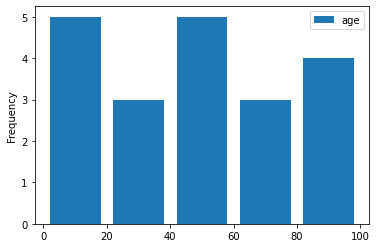

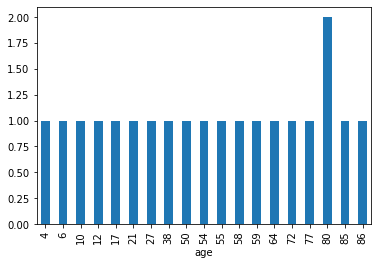

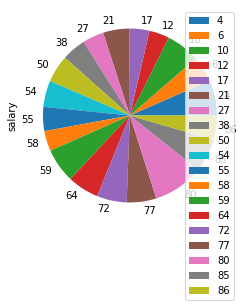

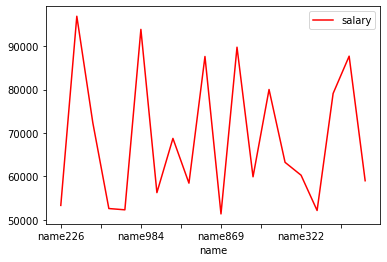

In [14]:
#convert spark df to pandas df
pdf = loadedDFWithSchema.toPandas()
#print(pdf)

#Histogram
pdf[['age']].head(20).plot(kind='hist',bins=[0,20,40,60,80,100],rwidth=0.8)
plt.show()

#Bar graph
pdf.head(20).groupby('age')['name'].nunique().plot(kind='bar')
plt.show()

#pie chart
pdf.head(20).groupby(['age']).sum().plot(kind='pie', y='salary')
plt.show()

#Line Plot
# gca stands for 'get current axis'
ax = plt.gca()
pdf.tail(20).plot(kind='line',x='name',y='salary', color='red', ax=ax)
plt.show()

# Querying Aerospike Data using SparkSQL
#### Things to keep in mind
   1. Queries that involve Primary Key in the predicate trigger aerospike_batch_get()[hyper link: https://www.aerospike.com/docs/client/c/usage/kvs/batch.html] and run extremely fast. For e.g. a query containing `__key` with, with no `OR` between two bins.
   2. All other queries may entail a full scan of the Aerospike DB if they can’t be converted to Aerospike batchget. 

## Queries that include Primary Key in the Predicate

In case of batchget queries we can also apply filters upon metadata columns like `__gen` or `__ttl` etc. To do so, these columns should be exposed through schema (if schema provided). 

In [19]:
batchGet1= spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.seedhost", AS_HOST) \
.option("aerospike.featurekey", AS_FEATURE_KEY_PATH) \
.option ("aerospike.namespace", AS_NAMESPACE) \
.option("aerospike.set", "py_input_data") \
.option("aerospike.keyType", "int") \
.load().where("__key = 829") \

batchGet1.show()
#Please be aware ASDB only supports equality test with PKs in primary key query. 
#So, a where clause with "__key >10", would result in scan query!

+-----+--------------------+--------+------------+-----+---+-------+------+---+
|__key|            __digest|__expiry|__generation|__ttl|age|   name|salary|_id|
+-----+--------------------+--------+------------+-----+---+-------+------+---+
|  829|[9A E9 5B 0A 11 6...|       0|           5|   -1| 29|name829| 67920|829|
+-----+--------------------+--------+------------+-----+---+-------+------+---+



In [20]:
#In this query we are doing *OR* between PK subqueries 
from pyspark.sql.functions import *
somePrimaryKeys= list(range(1,10))
someMoreKeys= list(range(12,14))
batchGet2= spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.seedhost",AS_HOST) \
.option("aerospike.featurekey", AS_FEATURE_KEY_PATH) \
.option ("aerospike.namespace", AS_NAMESPACE) \
.option("aerospike.set", "py_input_data") \
.option("aerospike.keyType", "int") \
.load().where((col("__key").isin(somePrimaryKeys)) | ( col("__key").isin(someMoreKeys))) 

batchGet2.show(5)
#We should got in total 'len(somePrimaryKeys) + len(someMoreKeys)' records.

+-----+--------------------+--------+------------+-----+---+------+------+---+
|__key|            __digest|__expiry|__generation|__ttl|age|  name|salary|_id|
+-----+--------------------+--------+------------+-----+---+------+------+---+
|    4|[FE E0 77 E4 17 F...|       0|           5|   -1|  4| name4| 87227|  4|
|    5|[FF 00 39 4A 07 0...|       0|           5|   -1|  5| name5| 63640|  5|
|    7|[8B F3 60 83 F9 6...|       0|           5|   -1|  7| name7| 89687|  7|
|   13|[D7 B4 65 3D FA 4...|       0|           5|   -1| 13|name13| 90957| 13|
|    3|[75 25 0A 1D C0 4...|       0|           5|   -1|  3| name3| 91217|  3|
+-----+--------------------+--------+------------+-----+---+------+------+---+
only showing top 5 rows



## Queries that do not include Primary Key in the Predicate

In [21]:
somePrimaryKeys= list(range(1,10))
scanQuery1= spark \
.read \
.format("com.aerospike.spark.sql") \
.option("aerospike.seedhost", AS_HOST) \
.option ("aerospike.namespace", AS_NAMESPACE) \
.option("aerospike.featurekey", AS_FEATURE_KEY_PATH) \
.option("aerospike.set", "py_input_data") \
.option("aerospike.keyType", "int") \
.load().where((col("__key").isin(somePrimaryKeys)) | ( col("age") >50 ))

scanQuery1.show()

#Since there is OR between PKs and Bin. It will be treated as Scan query. 
#Primary keys are not stored in bins(by default), hence only filters corresponding to bins are honored.  

+-----+--------------------+--------+------------+-----+---+-------+------+---+
|__key|            __digest|__expiry|__generation|__ttl|age|   name|salary|_id|
+-----+--------------------+--------+------------+-----+---+-------+------+---+
| null|[0B 70 8A F2 9F A...|       0|           5|   -1| 86|name586| 68311|586|
| null|[13 D0 09 FD 8E E...|       0|           5|   -1| 77|name477| 82885|477|
| null|[17 B0 1E 54 2C 9...|       0|           5|   -1| 54|name554| 73406|554|
| null|[18 10 E6 C8 15 6...|       0|           5|   -1| 64|name964| 87713|964|
| null|[1C 30 1B 8B DC E...|       0|           5|   -1| 80|name880| 88669|880|
| null|[25 B0 10 82 C7 6...|       0|           5|   -1| 59|name859| 96151|859|
| null|[35 D0 BA A7 35 7...|       0|           5|   -1| 80|name780| 53021|780|
| null|[3C 80 4A 91 AA 3...|       0|           5|   -1| 55|name555| 67400|555|
| null|[3D C0 3E 1E 0D C...|       0|           5|   -1| 85|name185| 92506|185|
| null|[47 10 14 58 CA 7...|       0|   

## Query with CDT

In [22]:
#Find people who have had at least 5 jobs in the past
from pyspark.sql.functions import col, size

loadedComplexDFWithSchema \
.withColumn("past_jobs", col("work_history.company_name")) \
.withColumn("num_jobs", size(col("past_jobs")))  \
.where(col("num_jobs") > 4) \
.show(5)

+--------------------+-----------+--------------------+--------------------+--------------------+--------+
|                name|        SSN|        home_address|        work_history|           past_jobs|num_jobs|
+--------------------+-----------+--------------------+--------------------+--------------------+--------+
|[Tami, [[Joseph, ...|001-49-0685|[[23288, [Clark V...|[[Roberts PLC, [4...|[Roberts PLC, Hub...|       5|
|[Chelsea, [[Melis...|465-88-7213|[[49305, [Ward By...|[[Ochoa and Sons,...|[Ochoa and Sons, ...|       5|
|[Jonathan, [[Robe...|526-54-7792|[[71421, [William...|[[Henderson-Shaw,...|[Henderson-Shaw, ...|       5|
|[Gary, [[Cameron,...|825-55-3247|[[66428, [Kim Mil...|[[Bishop, Scott a...|[Bishop, Scott an...|       5|
|[Danielle, [[Mich...|319-30-0983|[[63276, [Bauer C...|[[Powers LLC, [60...|[Powers LLC, Powe...|       5|
+--------------------+-----------+--------------------+--------------------+--------------------+--------+
only showing top 5 rows



## Use Aerospike Spark Connector Configuration properties in the Spark API to improve performance 

  - aerospike.partition.factor: number of logical aerospike partitions [0-15]
  - aerospike.maxthreadcount : maximum number of threads to use for writing data into Aerospike
  - aerospike.compression : compression of java client-server communication
  - aerospike.batchMax : maximum number of records per read request (default 5000)
  - aerospike.recordspersecond : same as java client

#### Other
  - aerospike.keyType : Primary key type hint for schema inference. Always set it properly if primary key type is not string  

See https://www.aerospike.com/docs/connect/processing/spark/reference.html for detailed description of the above properties
